# Warfarin Parser

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="colorblind")

In [28]:
df = pd.read_csv('IWPC.csv')
org_df = df.copy()

# Filter only subjects that reached stable dose of warfarin and stable observed INR
df = df[(df["Subject Reached Stable Dose of Warfarin"] == 1) & \
        (~df["Therapeutic Dose of Warfarin"].isna()) & \
        (~df["INR on Reported Therapeutic Dose of Warfarin"].isna())]

# Define age groups
df['Age'] = df['Age'].fillna('')
agegroups = sorted(df['Age'].unique())

# Define a function to generate column values
def generate_column_value(x, value):
    return np.where(x == value, 1, 0)

# Demogrpahics
df['male'] = generate_column_value(df['Gender'], 'male')
df['white'] = generate_column_value(df['Race (OMB)'], 'White')
df['asian'] = generate_column_value(df['Race (OMB)'], 'Asian')
df['black'] = generate_column_value(df['Race (OMB)'], 'Black or African American')
df['non_hispanic'] = generate_column_value(df['Ethnicity (OMB)'], 'not Hispanic or Latino')
df['age_group'] = df['Age'].apply(lambda x: agegroups.index(x) if x in agegroups else 0)
df['no_age'] = df['Age'].apply(lambda x: 1 if x not in agegroups or agegroups.index(x) == 0 else 0)
df['height'] = df['Height (cm)']
df['weight'] = df['Weight (kg)']
df['bmi'] = df['weight'] * 100 * 100 / (df['height'] * df['height'])

# Indication for Warfarin Treatment
for i in range(1,9):
    df['indication for warfarin treatment: ' + str(i)] = df['Indication for Warfarin Treatment'].str.contains(str(i))
    df['indication for warfarin treatment: ' + str(i)] = df['indication for warfarin treatment: ' + str(i)].fillna(0)

# Comorbidities
df['diabetes_0'] = generate_column_value(df['Diabetes'], 0)
df['diabetes_1'] = generate_column_value(df['Diabetes'], 1)
df['CHF_cardiomyopathy_0'] = generate_column_value(df['Congestive Heart Failure and/or Cardiomyopathy'], 0)
df['CHF_cardiomyopathy_1'] = generate_column_value(df['Congestive Heart Failure and/or Cardiomyopathy'], 1)
df['valve_replacement_0'] = generate_column_value(df['Valve Replacement'], 0)
df['valve_replacement_1'] = generate_column_value(df['Valve Replacement'], 1)

# Medications
medication_cols = list(df.iloc[:, 17:35].columns)
for col in medication_cols:
    df[col + "_0"] = generate_column_value(df[col], 0)
    df[col + "_1"] = generate_column_value(df[col], 1)

# Smoker
df['smoker_0'] = generate_column_value(df['Current Smoker'], 0)
df['smoker_1'] = generate_column_value(df['Current Smoker'], 1)

# Genetic variants
df['CYP2C9_*1/*1'] = generate_column_value(df['CYP2C9 consensus'], '*1/*1')
df['CYP2C9_*1/*2'] = generate_column_value(df['CYP2C9 consensus'], '*1/*2')
df['CYP2C9_*1/*3'] = generate_column_value(df['CYP2C9 consensus'], '*1/*3')
df['CYP2C9_NA'] = np.where((df['CYP2C9 consensus'].isna()) | (df['CYP2C9 consensus'] == ''), 1, 0)

# VKORC1_variants
for i in range(60, 67): 
    col = df.iloc[:,i]
    values = col.dropna().unique()
    for val in values:
        col_name = col.name
        new_col = col_name.split("consensus")[0] + str(val)
        df[new_col] = generate_column_value(df[col_name], val)

In [3]:
# Drop unnecessary columns
remain_cols = ['Target INR', 'Therapeutic Dose of Warfarin',
               'INR on Reported Therapeutic Dose of Warfarin']
columns_to_drop = [c for c in org_df.columns if c not in remain_cols]
df.drop(columns=columns_to_drop, inplace=True)
print(df.shape)

# Filter out columns with small std
df = df[df.columns[df.std() >= .05]]
print(df.shape)

# filter out by where BMI is nonzero 
df = df[df['bmi'] > 0.003]
print(df.shape)

df = df.reset_index(drop=True)
df = df.astype(float)
df.head(3)

(4850, 90)
(4850, 84)
(3964, 84)


,Target INR,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,male,white,asian,black,non_hispanic,age_group,no_age,...,VKORC1 1542 G/G,VKORC1 3730 A/G,VKORC1 3730 G/G,VKORC1 3730 A/A,VKORC1 2255 T/T,VKORC1 2255 C/T,VKORC1 2255 C/C,VKORC1 -4451 C/C,VKORC1 -4451 A/C,VKORC1 -4451 A/A
0,2.5,49.0,2.60,1.0,1.0,0.0,0.0,1.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.5,42.0,2.15,0.0,1.0,0.0,0.0,1.0,5.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.5,53.0,1.90,0.0,1.0,0.0,0.0,1.0,4.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
rename_dict = {'Target INR' : 'target_INR',
               'Therapeutic Dose of Warfarin' : 'therapeutic_dose',
               'INR on Reported Therapeutic Dose of Warfarin' : 'obs_INR'}

df = df.rename(columns=rename_dict)

# Initial Analysis

<AxesSubplot:xlabel='therapeutic_dose', ylabel='Density'>

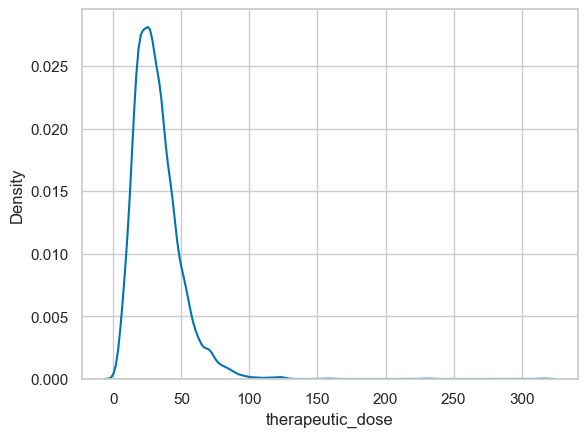

In [6]:
sns.kdeplot(df["therapeutic_dose"])

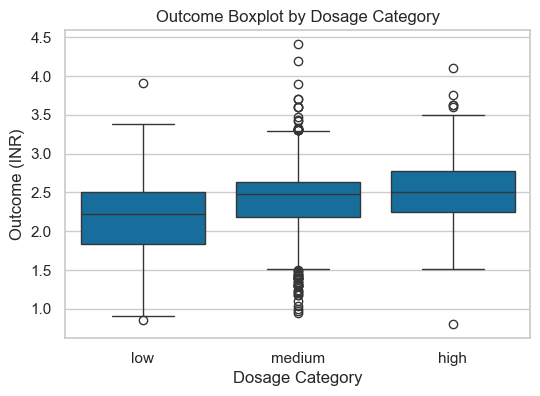

In [8]:
plot_df = df.copy()

plot_df["level"] = np.nan
plot_df["level"] = np.where(plot_df['therapeutic_dose'] < 21, "low", plot_df["level"])
plot_df["level"] = np.where((plot_df['therapeutic_dose'] > 21) & (plot_df['therapeutic_dose'] < 49), "medium", plot_df["level"])
plot_df["level"] = np.where(plot_df['therapeutic_dose'] > 49, "high", plot_df["level"])


plt.figure(figsize=(6, 4))
sns.boxplot(x='level', y='obs_INR', data=plot_df, order=["low", "medium", "high"])
plt.xlabel('Dosage Category')
plt.ylabel('Outcome (INR)')
plt.title('Outcome Boxplot by Dosage Category')
plt.show()

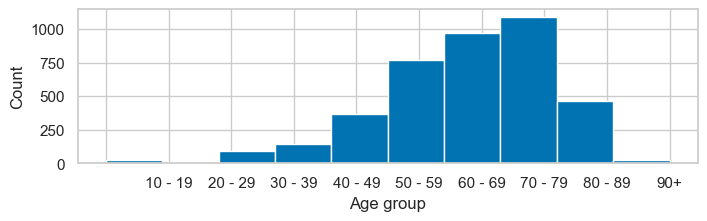

In [9]:
plot_df = df.copy()
plot_df['age_group_str'] = plot_df['age_group'].astype(int).map(lambda x: agegroups[x])
plt.figure(figsize=(8, 2))
plot_df = plot_df.sort_values(by='age_group_str')
plt.hist(plot_df['age_group_str'], edgecolor="white")
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

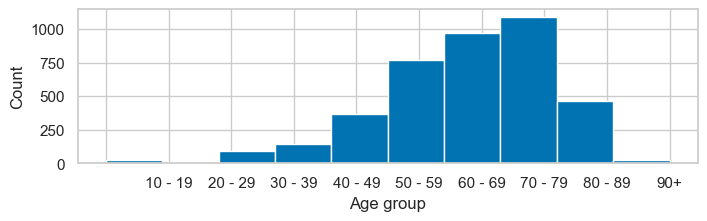

In [10]:
plot_df = df.copy()
plot_df['age_group_str'] = plot_df['age_group'].astype(int).map(lambda x: agegroups[x])
plt.figure(figsize=(8, 2))
plot_df = plot_df.sort_values(by='age_group_str')
plt.hist(plot_df['age_group_str'], edgecolor="white")
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

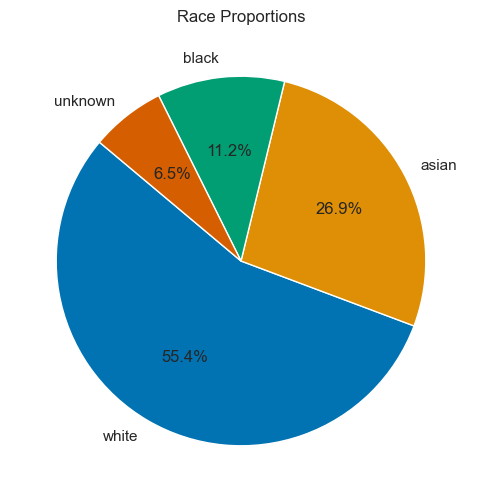

In [11]:
plot_df = df.copy()
plot_df['unknown'] = plot_df[['white', 'asian', 'black']].sum(axis=1) == 0

proportions = plot_df[['white', 'asian', 'black', 'unknown']].sum()

plt.figure(figsize=(6, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=140)
plt.title('Race Proportions')
plt.show()

# Semi-synthetic simulation

In [12]:
high_treatshold = 35

In [13]:
sim1_df = df.copy()

sim1_df['dose_category'] = np.where((sim1_df['therapeutic_dose'] > high_treatshold), 1, 0)
TREATMENT_OUTCOME_COLS = ['target_INR', 'therapeutic_dose', 'obs_INR', 'dose_category']

sim1_df['y0'] = np.where(sim1_df['dose_category'] == 0, 1, 0)
sim1_df['y1'] = np.where(sim1_df['dose_category'] == 1, 1, 0)
sim1_df = sim1_df.drop(columns=TREATMENT_OUTCOME_COLS)

print(sim1_df.shape)
print(f"Y1 prop. {sim1_df[['y1']].sum() / len(sim1_df)}")
sim1_df.to_csv(f"./parsed/iwpc_parsed.csv")
sim1_df.head(5)

(3964, 83)
Y1 prop. y1    0.310797
dtype: float64


,male,white,asian,black,non_hispanic,age_group,no_age,height,weight,bmi,...,VKORC1 3730 G/G,VKORC1 3730 A/A,VKORC1 2255 T/T,VKORC1 2255 C/T,VKORC1 2255 C/C,VKORC1 -4451 C/C,VKORC1 -4451 A/C,VKORC1 -4451 A/A,y0,y1
0,1.0,1.0,0.0,0.0,1.0,6.0,0.0,193.04,115.7,31.048365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,0.0,1.0,0.0,0.0,1.0,5.0,0.0,176.53,144.2,46.273060,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1
2,0.0,1.0,0.0,0.0,1.0,4.0,0.0,162.56,77.1,29.176084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,1.0,1.0,0.0,0.0,1.0,6.0,0.0,182.24,90.7,27.309885,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,1.0,1.0,0.0,0.0,1.0,5.0,0.0,167.64,72.6,25.833385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
